In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
fights_file = 'fights_test.csv'
payers_file = 'payers_test.csv'

fights = pd.read_csv(fights_file, index_col=0)
payers = pd.read_csv(payers_file, index_col=0)

#посчитал и добавил общую сумму платежей для каждого игрока 
id_pay = payers.groupby('player_id')['cost'].sum().reset_index()
fights = fights.merge(id_pay, how='left', on='player_id').set_index(fights.index)
fights.rename(columns={'cost':'total_paid'}, inplace=True)
print(fights.head())

   player_id      reg_ts    event_ts mode      map  kills  total_paid
0        304  1611675782  1611762182   BR     pool      5         NaN
3         95  1612366982  1612971782   TF  assault     11         NaN
4        994  1612194182  1612626182   TF     dust      9      2509.0
7         15  1612712582  1612971782   DM  assault     11         NaN
9        905  1612626182  1612885382   TF     pool      6      2837.0


In [3]:
#создал копию df боев и платежей, чтоб посчитать DAU оттдельно
ft = fights.copy()
ft['event_date'] = pd.to_datetime(ft['event_ts'], unit='s').dt.date

p = payers.copy()
p['event_date'] = pd.to_datetime(p['event_ts'], unit='s').dt.date

    event_date  dau  payers  payers_part
0   2021-01-27  247      48        19.43
1   2021-01-28  430      80        18.60
2   2021-01-29  561      99        17.65
3   2021-01-30  677     116        17.13
4   2021-01-31  755     137        18.15
5   2021-02-01  803     159        19.80
6   2021-02-02  860     173        20.12
7   2021-02-03  897     175        19.51
8   2021-02-04  925     179        19.35
9   2021-02-05  937     183        19.53
10  2021-02-06  947     189        19.96
11  2021-02-07  955     181        18.95
12  2021-02-08  962     190        19.75
13  2021-02-09  980     197        20.10
14  2021-02-10  979     197        20.12
15  2021-02-11  990     193        19.49
16  2021-02-12  990     196        19.80
17  2021-02-13  993     196        19.74
18  2021-02-14  993     198        19.94


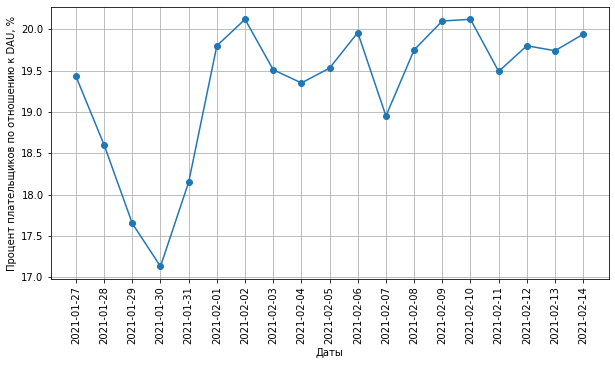

In [4]:
#рассчет DAU и количества уникальных плательщиков за каждый день
#соотношение плательщиков к DAU сохранено как payers_part

#DAU считается как количество уникальных пользователей как игравших матчи,
#так и совершавших покупки для каждого дня 
comb = ft[['player_id', 'event_date']].append(p[['player_id', 'event_date']])
dau = comb.groupby('event_date')['player_id'].nunique().reset_index()
dau.rename(columns={'player_id':'dau'}, inplace=True)

#платившие пользователи считаются как количество уникальных пользователей
#совершавших какую-либо покупку для каждого дня 
pp = p.groupby('event_date')['player_id'].nunique().reset_index()
pp.rename(columns={'player_id':'payers'}, inplace=True)
comb = dau.merge(pp, how='left', on='event_date')
comb['payers_part'] = round(comb['payers']/comb['dau']*100, 2)
dates = comb['event_date'].to_numpy()
payers_part = comb['payers_part'].to_numpy()

print(comb)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(dates, payers_part, marker='o')

plt.xlabel('Даты')
plt.ylabel('Процент плательщиков по отношению к DAU, %')
plt.xticks(ticks = np.arange(dates[0], dates[len(dates)-1]+datetime.timedelta(days=1), 1), labels = dates, rotation='vertical')

plt.grid(True)
plt.show()

In [5]:
#медиана и квартили для каждого игрока
#я тут предположил, что нас интересует сумма убийств на игрока, а не среднее значение
id_kills = fights.groupby('player_id')['kills'].sum().reset_index()
id_kills.rename(columns={'kills':'kill_sum'}, inplace=True)
print(id_kills['kill_sum'].describe())
#или если только квартили
print(id_kills['kill_sum'].quantile([0.25, 0.5, 0.75]))

count    999.000000
mean     473.350350
std       80.036298
min      228.000000
25%      418.000000
50%      473.000000
75%      528.000000
max      760.000000
Name: kill_sum, dtype: float64
0.25    418.0
0.50    473.0
0.75    528.0
Name: kill_sum, dtype: float64


In [6]:
#считаем количество киллов по режиму и карте
map_mode_kills = fights.pivot_table(index='map', columns='mode', values='kills', aggfunc='sum')
print(map_mode_kills)

mode        BR     DM     TF
map                         
assault  51856  53435  53287
dust     53920  51140  53407
pool     52301  52248  51283


In [7]:
#считаем среднее и суммарное количество киллов по режиму и карте в разные дни!
date_mapmode_kills = ft.pivot_table(index='event_date', columns=['mode', 'map'],
                                   values='kills', aggfunc=['sum', 'mean'])
date_mapmode_kills['mean'] = date_mapmode_kills['mean'].round(2)
print(date_mapmode_kills)

               sum                                                      \
mode            BR                  DM                  TF               
map        assault  dust  pool assault  dust  pool assault  dust  pool   
event_date                                                               
2021-01-27     248   193   231     224   256   245     310   300   354   
2021-01-28     481   764   477     629   436   535     567   625   369   
2021-01-29     734   982   646     739   902   728     881   822   780   
2021-01-30    1233   896  1158    1049  1088  1046    1213  1137  1220   
2021-01-31    1391  1471  1106    1486  1266  1222    1451  1483  1345   
2021-02-01    1670  1698  1591    1769  1682  1562    1660  1529  1833   
2021-02-02    2016  1903  1799    1451  1987  2314    1899  2169  1901   
2021-02-03    2154  2059  2177    2165  2102  2136    2233  2457  2222   
2021-02-04    2557  2840  2603    2299  2192  2580    2750  2525  2531   
2021-02-05    2686  2714  2656    2804

In [8]:
#ДОП ЗАДАНИЕ!
#убивают ли платящие игроки чаще? Посчитаем среднее количество убийств
#1. для плательщиков
#2. для неплательщиков
#3. для всей группы пользователей 

#среднее число убийств для плательщика
payers2 = fights.dropna()
aver_payer_score = payers2.groupby('player_id')['kills'].mean().reset_index()['kills'].mean().round(2)

#среднее число убийств для неплательщика
non_payers = fights[fights['total_paid'].isna()]
aver_nonpayer_score = non_payers.groupby('player_id')['kills'].mean().reset_index()['kills'].mean().round(2)

#общее среднее число убийств 
aver_all = fights.groupby('player_id')['kills'].mean().reset_index()['kills'].mean().round(2)

print('Сравнение среднего числа убийств:')
print('Плательщик: ', aver_payer_score)
print('Неплательщик: ', aver_nonpayer_score)
print('Среднее значение: ', aver_all)

#Соответственно, в среднем, платящий игрок убивает реже, чем игрок, который не платит

Сравнение среднего числа убийств:
Плательщик:  9.92
Неплательщик:  9.96
Среднее значение:  9.95
